In [26]:
###GÖZETİMSİZ ÖĞRENME İLE MANTARLAR ZEHRİRLİ Mİ DEGİL Mİ 

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN
from sklearn.mixture import GaussianMixture
from scipy.optimize import linear_sum_assignment

from sklearn.metrics import (
    silhouette_score,adjusted_rand_score,confusion_matrix,accuracy_score,
    precision_score,recall_score, f1_score)


In [3]:
# VERİYİ YÜKLEME 
df = pd.read_csv("secondary_data_generated.csv", delimiter = ';')

In [4]:
# Orijinal sütun isimlerini yazdır
print("Orijinal Sütun İsimleri:")
print(list(df.columns))

#  Sütun adlarındaki boşlukları, \n gibi karakterleri temizle
df.columns = df.columns.str.strip().str.replace('\n', '', regex=True)

# Temizlenmiş hali
print("\n Temizlenmiş Sütun İsimleri:")
print(list(df.columns))


Orijinal Sütun İsimleri:
['class', 'cap-diameter', 'cap-shape', 'cap-surface', 'cap-color', 'does-bruise-or-bleed', 'gill-attachment', 'gill-spacing', 'gill-color', 'stem-height', 'stem-width', 'stem-root', 'stem-surface', 'stem-color', 'veil-type', 'veil-color', 'has-ring', 'ring-type', 'spore-print-color', 'habitat', 'season']

 Temizlenmiş Sütun İsimleri:
['class', 'cap-diameter', 'cap-shape', 'cap-surface', 'cap-color', 'does-bruise-or-bleed', 'gill-attachment', 'gill-spacing', 'gill-color', 'stem-height', 'stem-width', 'stem-root', 'stem-surface', 'stem-color', 'veil-type', 'veil-color', 'has-ring', 'ring-type', 'spore-print-color', 'habitat', 'season']


In [5]:
# Eksik değeri %50'den fazla olan sütunları sil

#Sütunlardaki eksik değer (NaN) sayılarını hesapla
null_counts = df.isnull().sum()

#  %50'den fazla eksik değeri olan sütunları belirle
cols_to_drop = null_counts[null_counts > 0.5 * len(df)].index
# Bu sütunları veri setinden çıkar
df_cleaned = df.drop(columns=cols_to_drop)

# Eksik kalanları mod ile doldur
for col in df_cleaned.columns:
    if df_cleaned[col].isnull().sum() > 0:
        df_cleaned[col] = df_cleaned[col].fillna(df_cleaned[col].mode()[0])


In [6]:
# Gereksiz büyük veri ile uğraşmamak için örnekleme
df_cleaned = df_cleaned.sample(n=2000, random_state=42)

In [7]:
# Hedef etiketi ayrı al (karşılaştırma için kullanılacak)
y = df_cleaned['class'] if 'class' in df_cleaned.columns else None
X = df_cleaned.drop('class', axis=1) if 'class' in df_cleaned.columns else df_cleaned.copy()

# Kategorik değişkenleri label encoding ile sayısal hale getir
for col in X.columns:
    if X[col].dtype == 'object':
        X[col] = LabelEncoder().fit_transform(X[col])# Her farklı kategoriyi sayısal değere çevir

# Ölçekleme--tüm sayısal veriler aynı ölçeğe getirilir (ortalama=0, std=1)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [8]:
# PCA (Sadece görselleştirme ve DBSCAN için)
pca = PCA(n_components=2)  # Veriyi 2 boyuta indirerek görselleştirmeye uygun hale getir
X_pca = pca.fit_transform(X_scaled)  # Ölçeklenmiş veriye PCA uygula ve dönüşümü gerçekleştir

In [9]:
# K-MEANS

#veride 2 sınıf var: zehirli/zehirsiz
kmeans = KMeans(n_clusters=2, random_state=42, n_init=10)
# Modele veriyi verip hangi kümeye ait olduklarını tahmin et
kmeans_labels = kmeans.fit_predict(X_scaled)
# Kümeleme sonucu ne kadar tutarlı
sil_kmeans = silhouette_score(X_scaled, kmeans_labels)
# Gerçek etiketlerle karşılaştırma yaparak ARI (Adjusted Rand Index) skorunu hesapla (y varsa)
ari_kmeans = adjusted_rand_score(LabelEncoder().fit_transform(y), kmeans_labels) if y is not None else None


# GMM
# 2 bileşenli GMM modeli tanımla
gmm = GaussianMixture(n_components=2, random_state=42)
# Modele veriyi verip hangi bileşene ait olduklarını tahmin et
gmm_labels = gmm.fit_predict(X_scaled)
sil_gmm = silhouette_score(X_scaled, gmm_labels)
ari_gmm = adjusted_rand_score(LabelEncoder().fit_transform(y), gmm_labels) if y is not None else None


# DBSCAN (PCA sonrası 2 boyutta)
#tanımla
dbscan = DBSCAN(eps=0.5, min_samples=5)
# PCA ile indirgenmiş veriyi kullanarak kümeleri tahmin et

dbscan_labels = dbscan.fit_predict(X_pca)

# Gürültü (-1 etiketli) verileri filtrele
filtered_labels = dbscan_labels[dbscan_labels != -1]
filtered_data = X_pca[dbscan_labels != -1]

# En az 2 farklı küme varsa metrikleri hesapla
if len(np.unique(filtered_labels)) > 1:
    sil_dbscan = silhouette_score(filtered_data, filtered_labels)
    ari_dbscan = adjusted_rand_score(LabelEncoder().fit_transform(y)[dbscan_labels != -1], filtered_labels) if y is not None else None

else:
     # Anlamlı küme oluşmadıysa skorları -1 olarak ayarla
    sil_dbscan = ari_dbscan = -1

C:\Users\aysen\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=8.
  warnings.warn(
C:\Users\aysen\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=8.
  warnings.warn(


In [10]:
#SONUÇLAR

results_unsupervised = pd.DataFrame({
    'Model': ['KMeans', 'GMM', 'DBSCAN'],
    'Silhouette': [sil_kmeans, sil_gmm, sil_dbscan],
    'ARI (Gerçek Sınıfa Göre)': [ari_kmeans, ari_gmm, ari_dbscan]
})

print("\nGözetimsiz Öğrenme Sonuçları:")
print(results_unsupervised)



Gözetimsiz Öğrenme Sonuçları:
    Model  Silhouette  ARI (Gerçek Sınıfa Göre)
0  KMeans    0.124556                  0.002602
1     GMM    0.126546                 -0.002684
2  DBSCAN    0.138728                 -0.003267


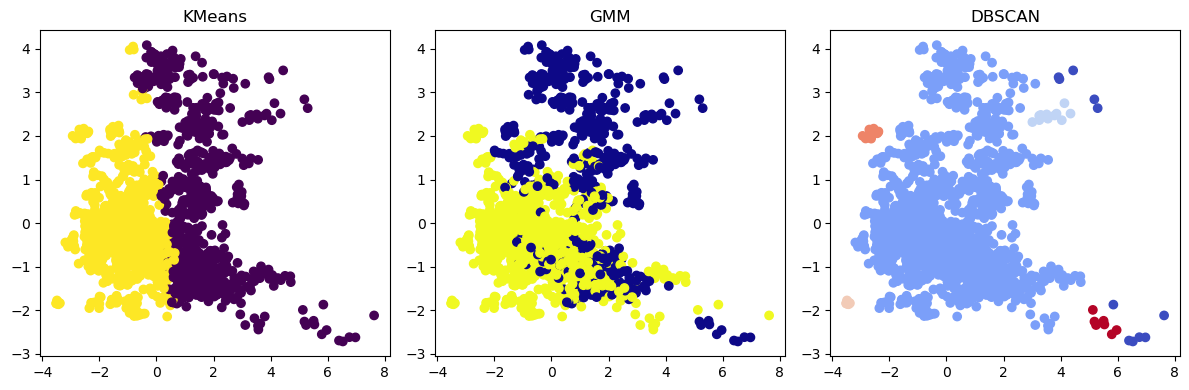

In [11]:
# GÖRSELLEŞTİRME

plt.figure(figsize=(12, 4))

#KNN
plt.subplot(1, 3, 1)
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=kmeans_labels, cmap='viridis')
plt.title("KMeans")

#GMM
plt.subplot(1, 3, 2)
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=gmm_labels, cmap='plasma')
plt.title("GMM")

#DBSCAN
plt.subplot(1, 3, 3)
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=dbscan_labels, cmap='coolwarm')
plt.title("DBSCAN")

plt.tight_layout()
plt.show()


In [13]:
# CSV OLARAK KAYDET
results_unsupervised.to_csv("unsupervised_results.csv", index=False)


In [14]:

def evaluate_unsupervised(true_labels, predicted_labels):
    true_labels = LabelEncoder().fit_transform(true_labels)
    predicted_labels = LabelEncoder().fit_transform(predicted_labels)

    cm = confusion_matrix(true_labels, predicted_labels)
    cost_matrix = -cm
    row_ind, col_ind = linear_sum_assignment(cost_matrix)

    mapping = dict(zip(col_ind, row_ind))
    predicted_aligned = [mapping[label] if label in mapping else label for label in predicted_labels]

    acc = accuracy_score(true_labels, predicted_aligned)
    prec = precision_score(true_labels, predicted_aligned, average='weighted', zero_division=0)
    rec = recall_score(true_labels, predicted_aligned, average='weighted')
    f1 = f1_score(true_labels, predicted_aligned, average='weighted')
    
    return acc, prec, rec, f1

# Örnek etiket kümeleri
clustering_results = {
    'KMeans': kmeans_labels,
    'GMM': gmm_labels,
    'DBSCAN': dbscan_labels
}

results = []

for name, labels in clustering_results.items():
    if name == 'DBSCAN' and -1 in labels:
        valid_idx = labels != -1
        acc, prec, rec, f1 = evaluate_unsupervised(y[valid_idx], labels[valid_idx])
    else:
        acc, prec, rec, f1 = evaluate_unsupervised(y, labels)

    results.append({
        'Model': name,
        'Accuracy': acc,
        'Precision': prec,
        'Recall': rec,
        'F1-score': f1
    })

df_results = pd.DataFrame(results)
print("\n--- Gözetimsiz Öğrenme Sonuçları ---")
print(df_results)

# En iyi modeli F1-score'a göre seçmek:
best_model = df_results.loc[df_results['F1-score'].idxmax()]
print("\nEn iyi model (F1-score'a göre):")
print(best_model)



--- Gözetimsiz Öğrenme Sonuçları ---
    Model  Accuracy  Precision    Recall  F1-score
0  KMeans  0.530500   0.525861  0.530500  0.527364
1     GMM  0.500500   0.481929  0.500500  0.483324
2  DBSCAN  0.553544   0.752364  0.553544  0.409964

En iyi model (F1-score'a göre):
Model          KMeans
Accuracy       0.5305
Precision    0.525861
Recall         0.5305
F1-score     0.527364
Name: 0, dtype: object


C:\Users\aysen\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


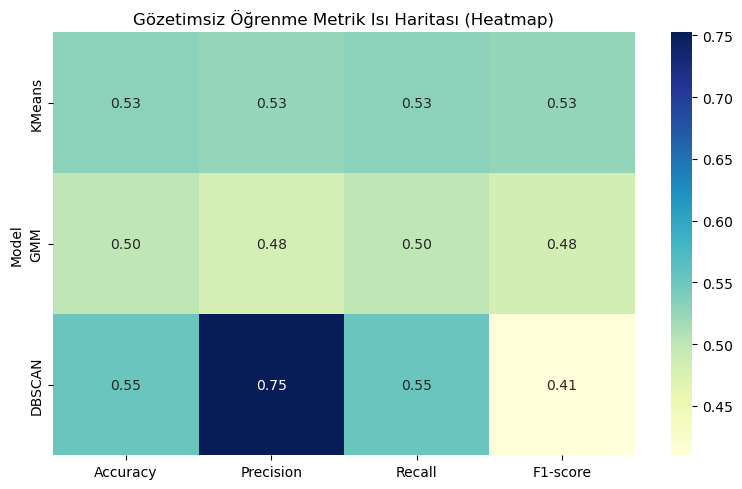

In [15]:
#Heatmap haritası
# Model isimlerini index olarak kullan
df_heatmap = df_results.set_index('Model')

plt.figure(figsize=(8, 5))
sns.heatmap(df_heatmap, annot=True, cmap='YlGnBu', fmt=".2f")
plt.title('Gözetimsiz Öğrenme Metrik Isı Haritası (Heatmap)')
plt.tight_layout()
plt.show()


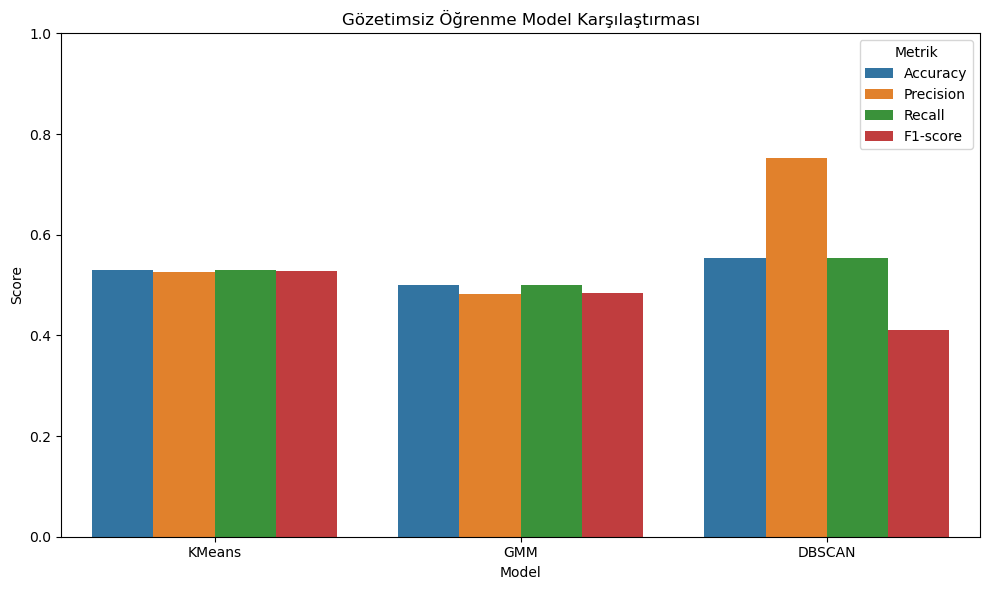

In [16]:
#Model karşılaştırması

# Grafik boyutlarını ayarla
plt.figure(figsize=(10, 6))
df_melted = df_results.melt(id_vars='Model', var_name='Metric', value_name='Score')

# Barplot çizimi
sns.barplot(data=df_melted, x='Model', y='Score', hue='Metric')
plt.title('Gözetimsiz Öğrenme Model Karşılaştırması')
plt.ylim(0, 1)
plt.legend(title='Metrik')
plt.tight_layout()
plt.show()
